# Local vs. global variance of connection counts
- Are neighboring cartridges more similar to each other in connection counts than non-neighboring cartridges?
- Does a circuit's connection counts vary stochastically across the eye, or are certain connection counts dependent on the retinotopic position of the lamina cartridge?
- By comparing the connection counts of all neighboring trios to randomly sampled non-neighboring trios, we can show the extent to which our methodology succeeds at capturing retinotopic variability that may exist in different regions of the eye. 

In [1]:
import os.path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
from scipy.stats import sem, mannwhitneyu, kstest, norm
from typing import Tuple
from itertools import combinations

from cx_analysis.utils import index_by_om, yymmdd_today

import matplotlib as mpl

In [2]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module

save_figs = True
fig_path = f'/mnt/home/nchua/Dropbox/lamina_figures/{yymmdd_today()}/filtered_cx/{yymmdd_today()}'

In [3]:
tp = '210809'
data_path = f'~/Data/{tp}_lamina/{tp}_cxdf.pickle'
mean_thresh = 0.0

cxdf = pd.read_pickle(data_path)

df_all = index_by_om(cxdf)
om_list = df_all.index

if mean_thresh > 0.0:
    included_cx = [cx for cx, mn in df_all.mean().items() if mn > mean_thresh]
    df = df_all[included_cx]
else:
    df = df_all
    
print(f"\n{len(df.columns)} included connection types. {len(df_all.columns) - len(df.columns)} excluded")
# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.png')


121 included connection types. 0 excluded


In [4]:
# Methods used to define neighboring and non-neighboring cartridge trios 
def id_to_ascii(om: str) -> Tuple:
    return ord(om[0]), int(om[1])

def coord_to_id(coord: Tuple) -> str:
    return ''.join((chr(coord[0]), str(coord[1])))

def triangle_subregions(om_list, d=1):
    subgroups = []
    for om in om_list:
        x, y = id_to_ascii(om)  # each ommatidia's hex coordinates
       
        up_left = {(x, y), (x, y + d), (x + d, y + d)}
        down_right = {(x, y), (x, y - d), (x - d, y - d)}
        
        # E4 and C6 are part of a pentagonal subgroup (no neighbor directly below/above in 2d hexgrid)
        if om == 'E4':  # neighbors are D3 and D2
            down_right = {(x, y), (x - d, y - d), (x - d, y - 2*d)}
        elif om == 'C6':  # neighbors are B6 and D7
            up_left = {(x, y), (x - d, y + d), (x + d, y + d)}

        # for hex subgroups, make a set out of {*up_left, *down_right, (x-1, y), (x+1, y)} 
        # discard subgroups with members that don't exist
        if all(coord_to_id(c) in om_list for c in up_left):
            subgroups.append(up_left)
        if all(coord_to_id(c) in om_list for c in down_right):
            subgroups.append(down_right)
        
    return [sorted([coord_to_id(a), coord_to_id(b), coord_to_id(c)]) for a, b, c in subgroups]
            
def fano(df: pd.DataFrame) -> pd.Series:
    mean = df.mean()
    stadev = df.std(ddof=0)
    ff = pd.Series([(sd ** 2)/mn if mn > 0.0 else 0.0 for sd, mn in zip(stadev, mean)], index=mean.index)
    return ff  
        

## We look at both the variance of each connection type its fano factor (variance/mean) across neighboring and non-neighboring trios

In [5]:
# Neighboring (local) trios
local_trios = triangle_subregions(om_list)

# Total variance and mean Fano-factor across all connection types
total_var = []
mean_fano = []
# Does not sum/average the variances or fano factors
all_var = []
all_fano = []

for trio in local_trios:
    trio_var = df.loc[trio].var(ddof=0)
    trio_fano = fano(df.loc[trio])
    
    for v, f in zip(trio_var.tolist(), trio_fano.tolist()):
        all_var.append(v)
        all_fano.append(f)

    total_var.append(trio_var.sum())
    mean_fano.append(trio_fano.mean())

local = pd.DataFrame(data={'trio': [a+b+c for a, b, c in local_trios], 
                           'total_var': total_var, 'mean_fano': mean_fano})
local_flat = pd.DataFrame(data={'var': all_var, 'fano': all_fano})

In [6]:
# Non-neighboring trios
# defined as all possible combinations of 3 cartridges minus all the neighboring trios computed above
non_local_trios = [sorted(list(trio)) for trio in combinations(om_list, 3) if sorted(list(trio)) not in local_trios]
# number of non-local trios should = NC3 - number of neighboring trios, where N is the number of ommatidia
assert(len(non_local_trios) == comb(len(om_list), 3, exact=True) - len(local_trios))

# Total variance and mean Fano-factor across all connection types
total_var = []
mean_fano = []
# Does not sum/average the variances or fano factors
all_var = []
all_fano = []

for trio in non_local_trios:
    trio_var = df.loc[trio].var(ddof=0)
    trio_fano = fano(df.loc[trio])
    
    for v, f in zip(trio_var.tolist(), trio_fano.tolist()):
        all_var.append(v)
        all_fano.append(f)

    total_var.append(trio_var.sum())
    mean_fano.append(trio_fano.mean())

non_local = pd.DataFrame(data={'trio': [a+b+c for a, b, c in non_local_trios], 
                               'total_var': total_var, 'mean_fano': mean_fano})
non_local_flat = pd.DataFrame(data={'var': all_var, 'fano': all_fano})

## Circuit variability of local retinotopic subgroups


Two sample Mann-Whitney U test (one tailed)

$H_{0}: P(\sigma^2_{local} > \sigma^2_{non-local}) >= 1/2 $

The variance in the connection counts of neighboring trios is more than or equal to the variance of non-neighboring trios  

$H_{1}: P(\sigma^2_{local} < \sigma^2_{non-local}) >= 1/2 $  

The variance in the connection counts of neighboring trios is less than the variance of non-local trios 

Test statistic: 42000.0, p-value:  2.5e-06


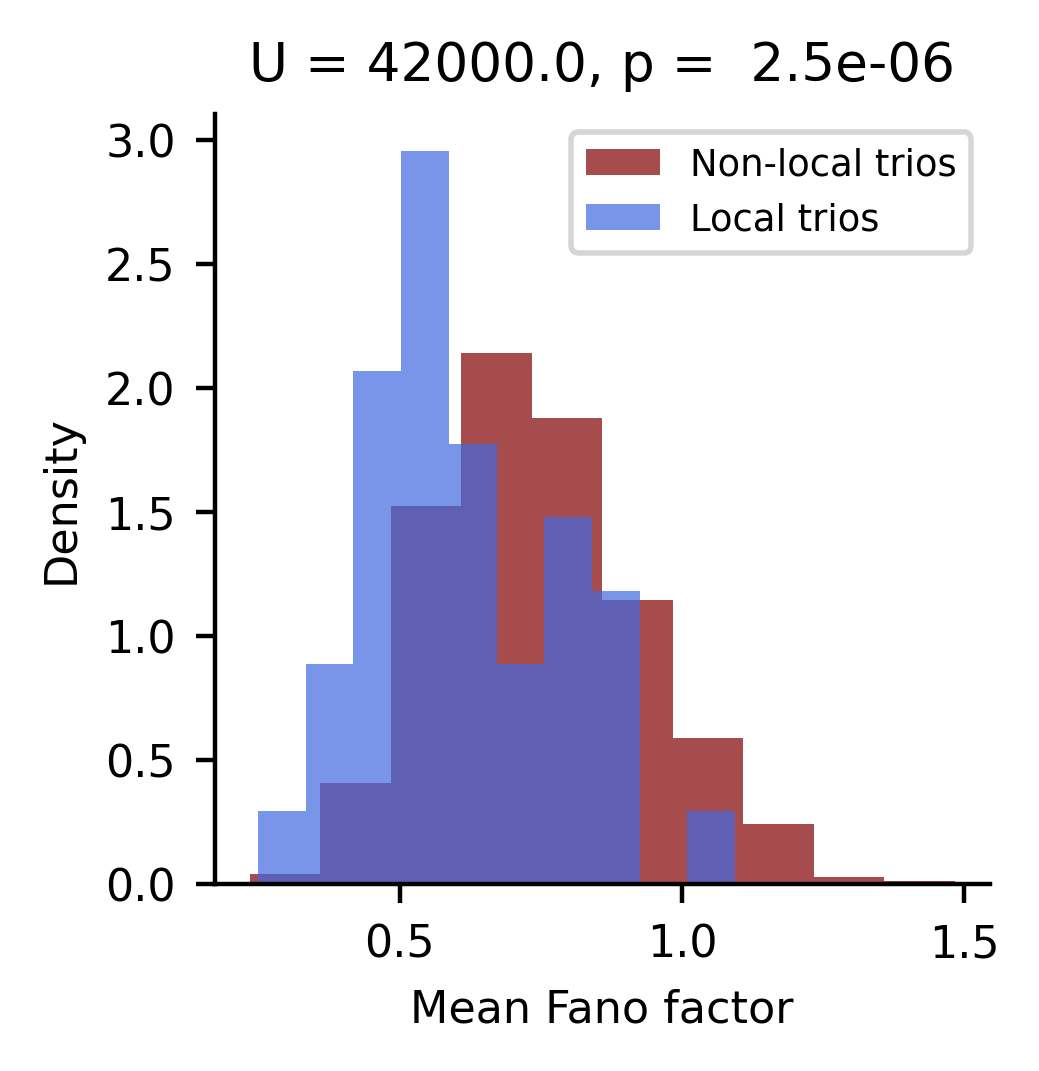

In [7]:
s, p = mannwhitneyu(local['mean_fano'], non_local['mean_fano'], alternative='less')
print(f"Test statistic: {s}, p-value: {p: .1e}")
#######################################################################################
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

ax.hist(non_local['mean_fano'], label=f'Non-local trios', density=True, 
        fc='maroon', alpha=0.7)#, bins=np.linspace(0,6,64))
ax.hist(local['mean_fano'], label=f'Local trios', density=True, 
        fc='royalblue', alpha=0.7)
             #ax=ax, label=f'Non-neighboring samples (n={len(non_local_trios)})')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_title(f'Average Fano factor of connection counts across three ommatidia')
ax.set_xlabel("Mean Fano factor")
ax.set_ylabel("Density")

ax.legend(fontsize='small')
ax.set_title(f'U = {s}, p = {p: .1e}')

if save_figs:
    fig.savefig(fig_path + f'RETVAR_localnonlocal-utest_{mean_thresh}cx.svg')
    fig.savefig(fig_path + f'RETVAR_localnonlocal-utest_{mean_thresh}cx.png')

Test statistic: 1030734877.5, p-value:  2.8e-04


Text(0.5, 1.0, 'U = 1030734877.5, p =  2.8e-04')

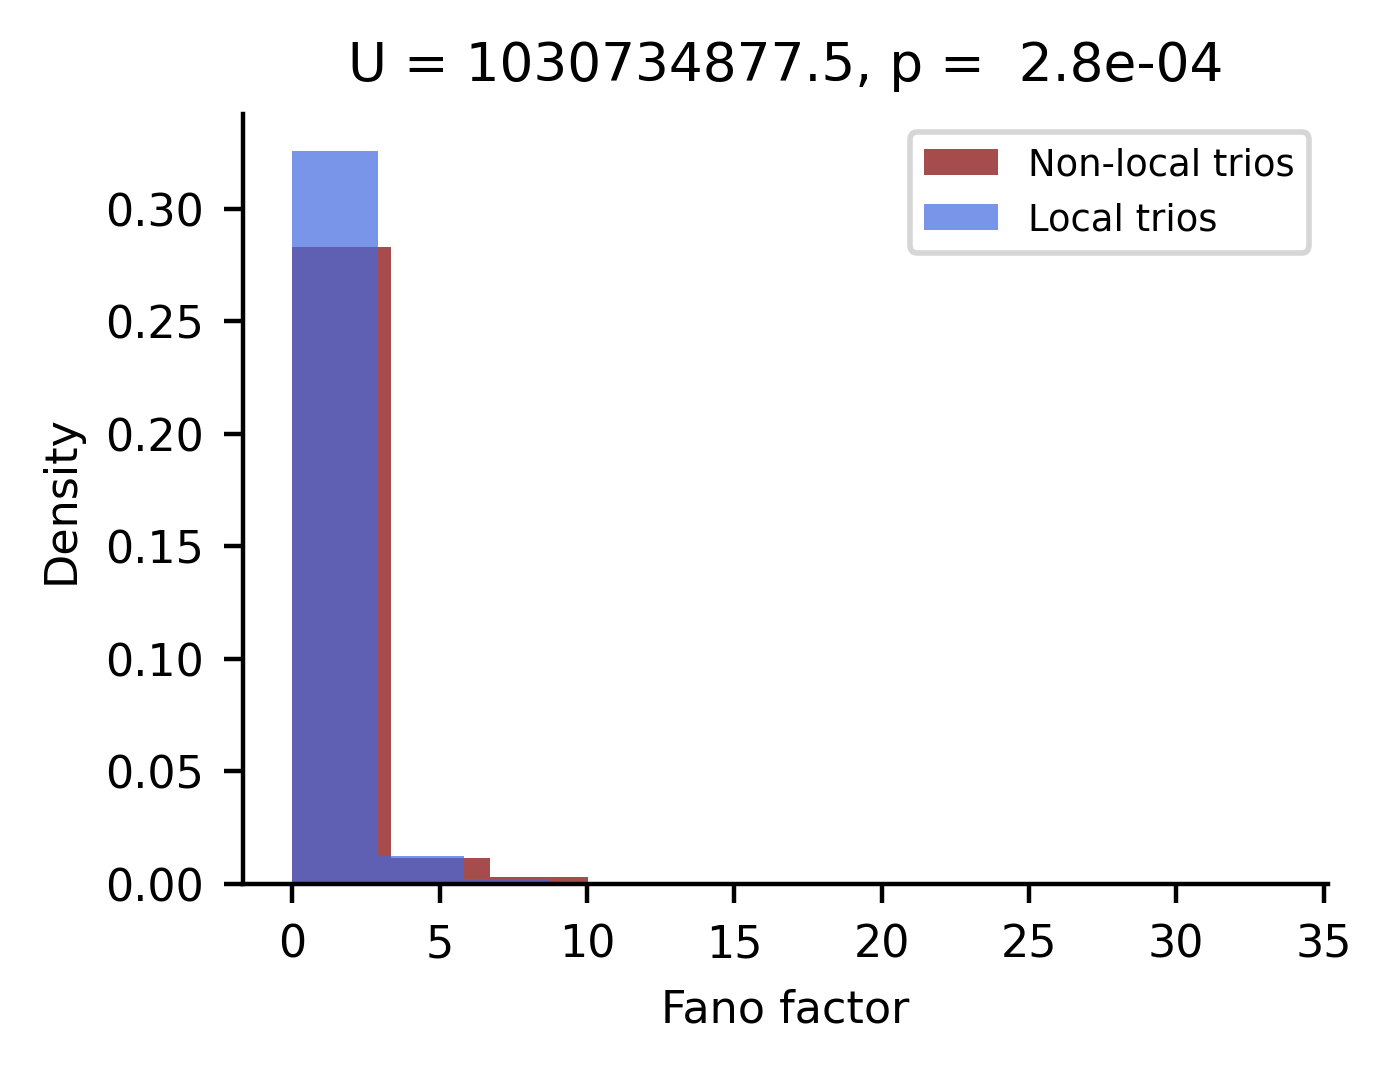

In [8]:
s, p = mannwhitneyu(local_flat['fano'], non_local_flat['fano'], alternative='less')
print(f"Test statistic: {s}, p-value: {p: .1e}")
#######################################################################################
fig, ax = plt.subplots(1, figsize=[3.5, 2.5])

ax.hist(non_local_flat['fano'], label=f'Non-local trios', density=True, 
        fc='maroon', alpha=0.7)#, bins=np.linspace(0,6,64))
ax.hist(local_flat['fano'], label=f'Local trios', density=True, 
        fc='royalblue', alpha=0.7)
             #ax=ax, label=f'Non-neighboring samples (n={len(non_local_trios)})')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_title(f'Average Fano factor of connection counts across three ommatidia')
ax.set_xlabel("Fano factor")
ax.set_ylabel("Density")

ax.legend(fontsize='small')
ax.set_title(f'U = {s}, p = {p: .1e}')

### KS Test

0.38028500276701716

5.938650293366711e-06

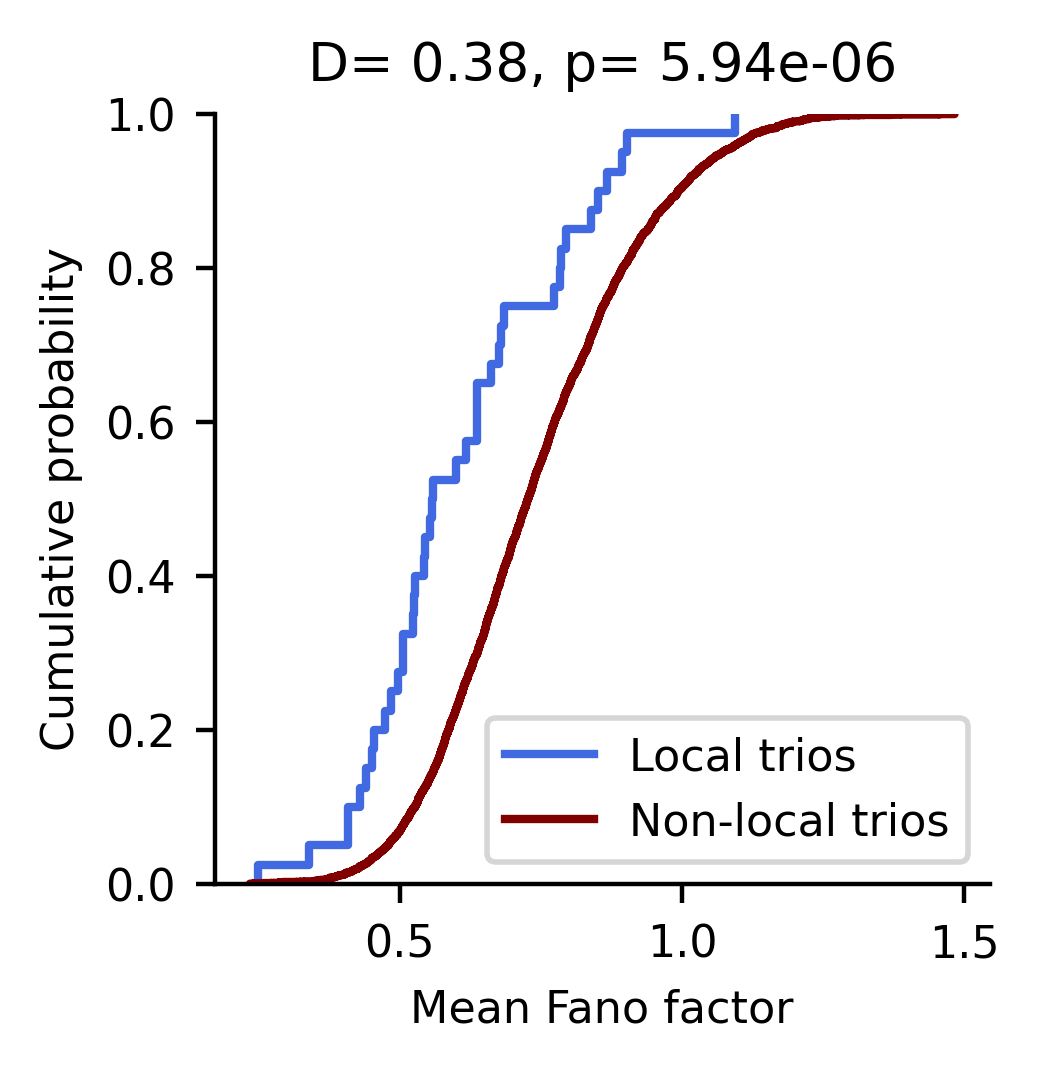

In [9]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

sns.ecdfplot(data=local['mean_fano'], ax=ax, label='Local trios', color='royalblue')
sns.ecdfplot(data=non_local['mean_fano'], ax=ax, label='Non-local trios', color='maroon', ls='-')

D, p = kstest(local['mean_fano'], non_local['mean_fano'], alternative='greater')

display(D)
display(p)

ax.set_ylabel('Cumulative probability')
ax.set_xlabel('Mean Fano factor')
ax.set_title(f'D={D: .2f}, p={p: .2e}')

ax.legend()

if save_figs:
    fig.savefig(fig_path + f'RETVAR_localnonlocal-KStest_{mean_thresh}cx.svg')
    fig.savefig(fig_path + f'RETVAR_localnonlocal-KStest_{mean_thresh}cx.png')

0.03872703490100482

5.657711258275468e-07

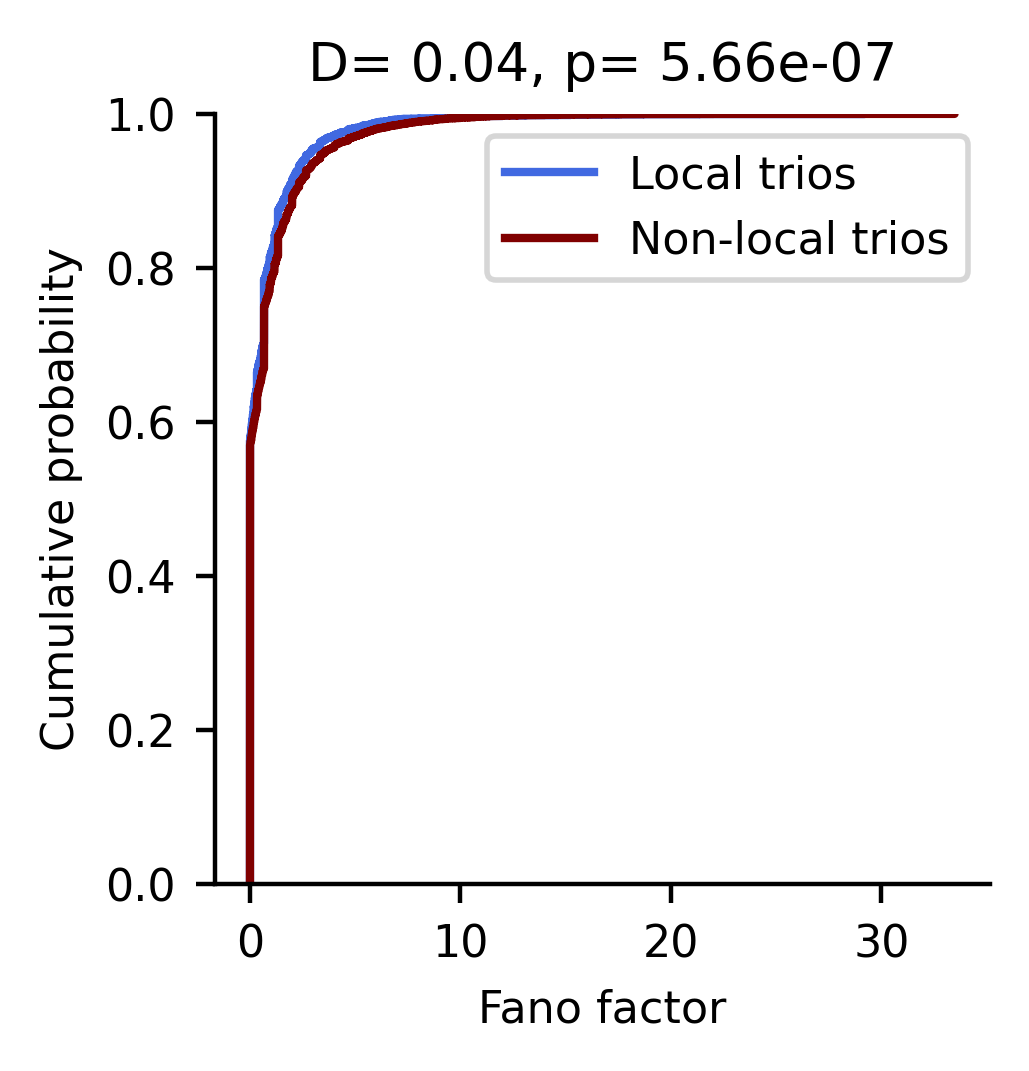

In [10]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

sns.ecdfplot(data=local_flat['fano'], ax=ax, label='Local trios', color='royalblue')
sns.ecdfplot(data=non_local_flat['fano'], ax=ax, label='Non-local trios', color='maroon', ls='-')

D, p = kstest(local_flat['fano'], non_local_flat['fano'], alternative='greater')

display(D)
display(p)

ax.set_ylabel('Cumulative probability')
ax.set_xlabel('Fano factor')
ax.set_title(f'D={D: .2f}, p={p: .2e}')

ax.legend()

**NOTE:** Scipy mannwhitneyu and kstest methods have an inconsistent way of specifying the one-tailed alternative hypothesis. 
- In mannwhitneyu(X, Y, alternative='greater'), the alternative hypothesis is that X > Y
- But in kstest(X, Y, alternative='greater'), the alternative hypothesis is that Y > X  
(see test below)

In [11]:
X = norm.rvs(loc=-0.5, size=1000)  # drawn from normal dist., mean = -0.5 
Y = norm.rvs(loc=0.5, size=1000)  # drawn from normal dist., mean = 0.5

s, p = kstest(X, Y, alternative='less')
display(s)
display(p)

u, p = mannwhitneyu(X, Y, alternative='less')
display(u)
display(p)

0.0

1.0

228913.0

3.7979422760755546e-98